# **Fraud Detection using AutoEncoder (PyOD)**
This notebook builds and evaluates an unsupervised fraud detection model using:
- PyOD AutoEncoder
- Kaggle dataset loaded via `kagglehub`

**Compatible with Google Colab**

In [1]:
!pip install pyod kagglehub[pandas-datasets] --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 3.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

from pyod.models.auto_encoder import AutoEncoder

import kagglehub
from kagglehub import KaggleDatasetAdapter

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 📥 Load Dataset from KaggleHub

In [3]:
# Load dataset using KaggleHub (no manual download needed)
dataset_owner = "whenamancodes/fraud-detection"
file_path = "creditcard.csv"  # file inside dataset

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    dataset_owner,
    file_path
)

print("Dataset Loaded Successfully!")
df.head()

/tmp/ipython-input-67568844.py:5: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 66.0M/66.0M [00:01<00:00, 60.0MB/s]

Extracting zip of creditcard.csv...


Dataset Loaded Successfully!


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 🔍 Class Balance Check

In [4]:
class_counts = df['Class'].value_counts()
print("Class distribution:\n", class_counts)
fraud_ratio = class_counts[1] / class_counts.sum()
print(f"Fraud Ratio: {fraud_ratio:.6f} ({fraud_ratio*100:.4f}%)")

Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64
Fraud Ratio: 0.001727 (0.1727%)


## 🧹 Preprocessing & Train/Test Split

In [5]:
X = df.drop(columns=['Class'])
y = df['Class']

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (227845, 30)
Test shape: (56962, 30)


## 🧠 Train PyOD AutoEncoder

In [10]:
import inspect
from pyod.models.auto_encoder import AutoEncoder

# Get the signature of the __init__ method
init_signature = inspect.signature(AutoEncoder.__init__)

# Print the parameters
print("Parameters of AutoEncoder.__init__:")
for name, param in init_signature.parameters.items():
    print(f"  {name}: {param.kind} (default: {param.default})")

Parameters of AutoEncoder.__init__:
  self: POSITIONAL_OR_KEYWORD (default: <class 'inspect._empty'>)
  contamination: POSITIONAL_OR_KEYWORD (default: 0.1)
  preprocessing: POSITIONAL_OR_KEYWORD (default: True)
  lr: POSITIONAL_OR_KEYWORD (default: 0.001)
  epoch_num: POSITIONAL_OR_KEYWORD (default: 10)
  batch_size: POSITIONAL_OR_KEYWORD (default: 32)
  optimizer_name: POSITIONAL_OR_KEYWORD (default: adam)
  device: POSITIONAL_OR_KEYWORD (default: None)
  random_state: POSITIONAL_OR_KEYWORD (default: 42)
  use_compile: POSITIONAL_OR_KEYWORD (default: False)
  compile_mode: POSITIONAL_OR_KEYWORD (default: default)
  verbose: POSITIONAL_OR_KEYWORD (default: 1)
  optimizer_params: POSITIONAL_OR_KEYWORD (default: {'weight_decay': 1e-05})
  hidden_neuron_list: POSITIONAL_OR_KEYWORD (default: [64, 32])
  hidden_activation_name: POSITIONAL_OR_KEYWORD (default: relu)
  batch_norm: POSITIONAL_OR_KEYWORD (default: True)
  dropout_rate: POSITIONAL_OR_KEYWORD (default: 0.2)


In [13]:
contamination = y_train.mean()
print(f"Using contamination={contamination:.6f}")

clf = AutoEncoder(
    hidden_neuron_list=[32, 16, 16, 32],
    hidden_activation_name='relu',
    epoch_num=20,
    batch_size=256,
    optimizer_name='adam',
    dropout_rate=0.1,
    verbose=1,
    contamination=contamination,
    random_state=RANDOM_STATE
)

clf.fit(X_train)
print("Training complete. Threshold:", clf.threshold_)

Using contamination=0.001729


Training: 100%|██████████| 20/20 [03:23<00:00, 10.20s/it]


Training complete. Threshold: 19.720760313882618


Please run the above cell. The output will help us understand the expected parameters for the `AutoEncoder` class and resolve the `TypeError`.

## 📊 Model Evaluation

In [14]:
y_test_pred = clf.predict(X_test)
y_test_scores = clf.decision_function(X_test)

roc_auc = roc_auc_score(y_test, y_test_scores)
precision = precision_score(y_test, y_test_pred, zero_division=0)
recall = recall_score(y_test, y_test_pred, zero_division=0)
f1 = f1_score(y_test, y_test_pred, zero_division=0)
cm = confusion_matrix(y_test, y_test_pred)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, digits=4, zero_division=0))

ROC-AUC: 0.9418
Precision: 0.0435
Recall:    0.0510
F1-score:  0.0469

Confusion Matrix:
[[56754   110]
 [   93     5]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9984    0.9981    0.9982     56864
           1     0.0435    0.0510    0.0469        98

    accuracy                         0.9964     56962
   macro avg     0.5209    0.5245    0.5226     56962
weighted avg     0.9967    0.9964    0.9966     56962



## 📈 Visualize Anomaly Score Distribution

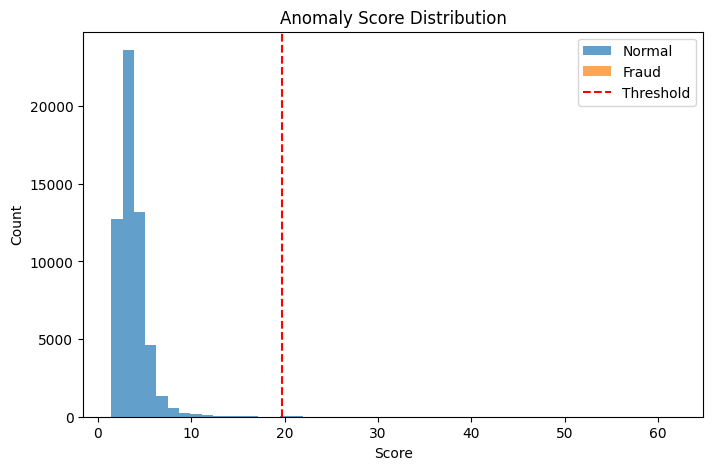

In [15]:
plt.figure(figsize=(8, 5))
plt.hist(y_test_scores[y_test == 0], bins=50, alpha=0.7, label='Normal')
plt.hist(y_test_scores[y_test == 1], bins=50, alpha=0.7, label='Fraud')
plt.axvline(clf.threshold_, color='red', linestyle='--', label='Threshold')
plt.title('Anomaly Score Distribution')
plt.xlabel('Score')
plt.ylabel('Count')
plt.legend()
plt.show()

## 💾 (Optional) Save Model

In [16]:
import joblib
joblib.dump(clf, "autoencoder_fraud_pyod.pkl")
joblib.dump(scaler, "scaler_robust.pkl")
print("Model and scaler saved.")

Model and scaler saved.


In [18]:
import joblib

# Load the saved AutoEncoder model
loaded_clf = joblib.load('autoencoder_fraud_pyod.pkl')

print("Model 'autoencoder_fraud_pyod.pkl' loaded successfully.")

Model 'autoencoder_fraud_pyod.pkl' loaded successfully.


In [19]:
y_test_pred_loaded = loaded_clf.predict(X_test)
y_test_scores_loaded = loaded_clf.decision_function(X_test)

print("Predictions using loaded model complete.")

Predictions using loaded model complete.


In [20]:
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

roc_auc_loaded = roc_auc_score(y_test, y_test_scores_loaded)
precision_loaded = precision_score(y_test, y_test_pred_loaded, zero_division=0)
recall_loaded = recall_score(y_test, y_test_pred_loaded, zero_division=0)
f1_loaded = f1_score(y_test, y_test_pred_loaded, zero_division=0)
cm_loaded = confusion_matrix(y_test, y_test_pred_loaded)

print(f"Loaded Model ROC-AUC: {roc_auc_loaded:.4f}")
print(f"Loaded Model Precision: {precision_loaded:.4f}")
print(f"Loaded Model Recall:    {recall_loaded:.4f}")
print(f"Loaded Model F1-score:  {f1_loaded:.4f}")

print("\nLoaded Model Confusion Matrix:")
print(cm_loaded)

print("\nLoaded Model Classification Report:")
print(classification_report(y_test, y_test_pred_loaded, digits=4, zero_division=0))

Loaded Model ROC-AUC: 0.9418
Loaded Model Precision: 0.0435
Loaded Model Recall:    0.0510
Loaded Model F1-score:  0.0469

Loaded Model Confusion Matrix:
[[56754   110]
 [   93     5]]

Loaded Model Classification Report:
              precision    recall  f1-score   support

           0     0.9984    0.9981    0.9982     56864
           1     0.0435    0.0510    0.0469        98

    accuracy                         0.9964     56962
   macro avg     0.5209    0.5245    0.5226     56962
weighted avg     0.9967    0.9964    0.9966     56962

